<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Semi_structured_and_multi_modal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps

*  use Unstructured to parse images, text, and tables from documents (PDFs).
* Usew the multi-vector retriever to store raw tables, text, (optionally) images along with their summaries for retrieval.
* Use a multimodal LLM (such as GPT4-V, LLaVA, or FUYU-8b) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

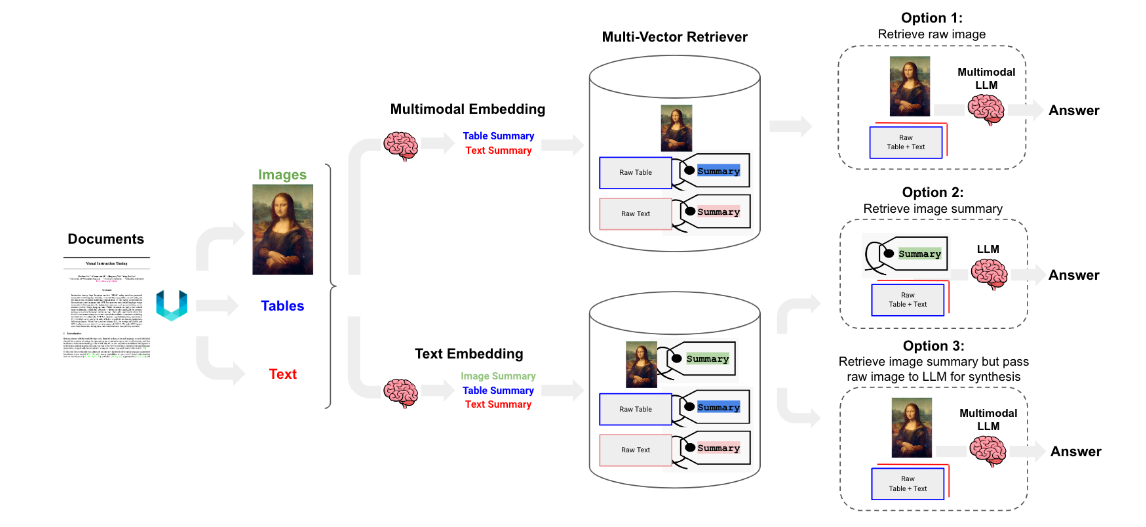

In [1]:
%%capture
! pip install langchain unstructured[all-docs] pydantic lxml langchainhub

In [6]:
%%capture
!apt-get install poppler-utils

In [7]:
%%capture
! apt install tesseract-ocr
! apt install libtesseract-dev

In [11]:
%%capture
! pip install Pillow
! pip install pytesseract

In [12]:
%%capture
!pip install llama-cpp-python

In [11]:
%%capture
!pip install openai

In [68]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.4/502.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.4/699.4 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 

In [4]:
! pip install gpt4all

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.8 MB/s eta 0:00:00


In [2]:
import os
os.mkdir("documents")

In [3]:
import shutil
shutil.move("/content/Building_Underwriting_Report-1.pdf","documents")

'documents/Building_Underwriting_Report-1.pdf'

In [13]:
from typing import Any
import os
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

path = "/content/documents/"
file_path = os.path.join("/content/documents","Building_Underwriting_Report-1.pdf")
# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "Building_Underwriting_Report-1.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/unstructured_inference/inference/layout.py", line 311, in extract_images
    write_image(cropped_image, output_f_path)
  File "/usr/local/lib/python3.10/dist-packages/unstructured_inference/utils.py", line 75, in write_image
    image.save(output_image_path)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 2438, in save
    save_handler(self, fp, filename)
  File "/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py", line 644, in _save
    raise ValueError(msg)
ValueError: cannot write empty image as JPEG
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/unstructured_inference/inference/layout.py", line 311, in extract_images
    write_image(cropped_image, output_f_path)
  File "/usr/local/lib/python3.10/dist-packages/unstructured_inference/utils.py", line 75, in write_image
    image.save(output_image_path)
  File "/usr/local/lib/python3.10/

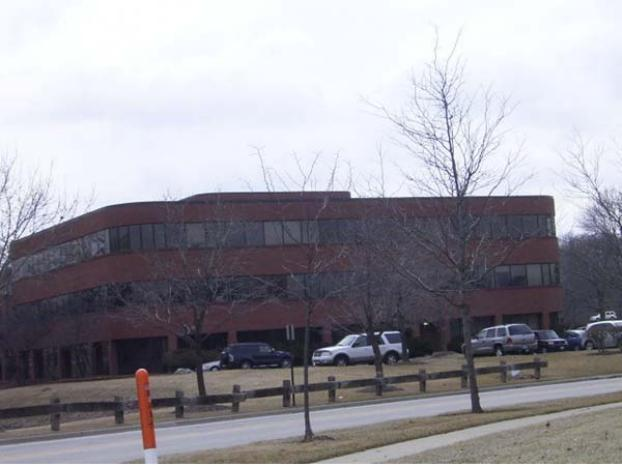

In [4]:
from PIL import Image
Image.open("/content/documents/figure-1-2.jpg")

In [7]:
Image.open("/content/documents/figure-11-20.jpg")

In [14]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 17,
 "<class 'unstructured.documents.elements.Table'>": 14}

In [15]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

14
17


## Multi-vector retriever


Summaries are used to retrieve raw tables and / or raw chunks of text.

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


In [16]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [17]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
text_summaries

['The Building Underwriting Report for DeStrong Financial Services, located at 1 Mendolice Ln, Griffith, NC 27999, includes various details about the building and its risk factors. The report includes photos, hazard grading, fire protection information, construction details, occupancy details, and other relevant information. The building was built in 2000 and was last surveyed on-site in March 2011. The report also includes aerial photos taken in March 2010.',
 'The document contains aerial photos and underwriting reports for a building located at 1 Mendolice Ln Griffith, NC 27999, owned by DeStrong Financial Services. The photos were taken on 03/15/2010 and provide south, west, and overhead views of the property. The building was built in 2000 and an on-site survey was conducted in 03/2011. The property is located in Armstrong County and has an ISO Risk ID of 32 5555 999999. The schedule was applied on 03/20/2008.',
 "The Relative Hazard Grading (RHG) is a numerical and graphical scal

In [18]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [19]:
table_summaries

['The text provides information about DeStrong Financial Services located at 1 Mendolice Ln, Griffith, NC 27999 in Armstrong County. The property is identified by ISO Risk ID: 32 5555 999999. An on-site survey was conducted in March 2011. The property was built in 2000 and the schedule was applied on March 20, 2008. The property is owned by Genco Family Trust with Frank Pantangelli as the contact person. Willie Cheech is in charge of maintenance. Contact phone numbers are provided for each individual. The text also mentions a relative hazard grading but does not provide specific details.',
 'The table presents the percentage of area hazards in different types of establishments. 3% of habitational mercantile areas have no hazards, while 16% of restaurants have hazards. 82% of office vacancies have no hazards, and the hazard status of non-manufacturing manufacturing building services is not specified.',
 'The underwriting report for a building with an area of 80,549 sq. ft indicates a me

In [66]:
import joblib
joblib.dump(text_summaries, "/content/text_summaries.pkl")
joblib.dump(table_summaries, "/content/table_summaries.pkl")

['/content/table_summaries.pkl']

## Image summaries
We will use LLaVA, an open source multimodal model.

We will use llama.cpp to run LLaVA locally (e.g., on a Mac laptop):

Clone llama.cpp


Download the LLaVA model: mmproj-model-f16.gguf and one of ggml-model-[f16|q5_k|q4_k].gguf from LLaVA 7b repo


Build
mkdir build && cd build && cmake ..
cmake --build .



Run inference across images:

```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

```

was not successful in using llama.cpp with LLAVA models hence used ```gpt-4-vision-preview model``` to generate images summaries

In [21]:
! wget https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/mmproj-model-f16.gguf

--2023-12-11 06:48:15--  https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/mmproj-model-f16.gguf
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38739 (38K) [text/html]
Saving to: ‘mmproj-model-f16.gguf’

mmproj-model-f16.gg 100%[===================>]  37.83K  --.-KB/s    in 0.006s  

2023-12-11 06:48:15 (5.79 MB/s) - ‘mmproj-model-f16.gguf’ saved [38739/38739]



In [22]:
!git clone https://github.com/ggerganov/llama.cpp.git

Cloning into 'llama.cpp'...
remote: Enumerating objects: 12974, done.
remote: Counting objects: 100% (3538/3538), done.
remote: Compressing objects: 100% (300/300), done.
remote: Total 12974 (delta 3377), reused 3298 (delta 3237), pack-reused 9436
Receiving objects: 100% (12974/12974), 15.47 MiB | 4.70 MiB/s, done.
Resolving deltas: 100% (9019/9019), done.


In [23]:
%cd llama.cpp

/content/llama.cpp


In [29]:
!pwd

/content/llama.cpp


In [30]:
!make llava-cli

I llama.cpp build info: 
I UNAME_S:   Linux
I UNAME_P:   x86_64
I UNAME_M:   x86_64
I CFLAGS:    -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c11   -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wshadow -Wstrict-prototypes -Wpointer-arith -Wmissing-prototypes -Werror=implicit-int -Werror=implicit-function-declaration -Wdouble-promotion -pthread -march=native -mtune=native 
I CXXFLAGS:  -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wmissing-declarations -Wmissing-noreturn -pthread  -Wno-array-bounds -Wno-format-truncation -Wextra-semi -march=native -mtune=native 
I NVCCFLAGS:  -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wmissing-declarations -Wmissing-noreturn -pthread    -Wno-pedantic -Xcompiler "-Wno-array-bounds -Wno-format-truncation -Wextra-semi -march=native -mt

In [31]:
!ls | grep llava

llava-cli


In [32]:
!wget https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/mmproj-model-f16.gguf

--2023-12-11 07:00:32--  https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/mmproj-model-f16.gguf
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38739 (38K) [text/html]
Saving to: ‘mmproj-model-f16.gguf’

mmproj-model-f16.gg 100%[===================>]  37.83K  --.-KB/s    in 0.006s  

2023-12-11 07:00:32 (5.82 MB/s) - ‘mmproj-model-f16.gguf’ saved [38739/38739]



In [42]:
!wget "https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/ggml-model-q4_k.gguf" -d "/content/llama.cpp/models/llava/"

DEBUG output created by Wget 1.21.2 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'ggml-model-q4_k.gguf' (UTF-8) -> 'ggml-model-q4_k.gguf' (UTF-8)
--2023-12-11 07:09:16--  https://huggingface.co/mys/ggml_llava-v1.5-7b/blob/main/ggml-model-q4_k.gguf
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.55, ...
Caching huggingface.co => 18.164.174.17 18.164.174.118 18.164.174.55 18.164.174.23 2600:9000:24ba:6800:17:b174:6d00:93a1 2600:9000:24ba:a00:17:b174:6d00:93a1 2600:9000:24ba:b200:17:b174:6d00:93a1 2600:9000:24ba:8200:17:b174:6d00:93a1 2600:9000:24ba:ac00:17:b174:6d00:93a1 2600:9000:24ba:f200:17:b174:6d00:93a1 2600:9000:24ba:fa00:17:b174:6d00:93a1 2600:9000:24ba:9c00:17:b174:6d00:93a1
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
Created socket 3.
Releasing 0x000058eb2f447ff0 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 3 to S

#### gpt-4-vision-preview model usage

In [50]:
import base64
import requests

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "/content/documents/figure-11-20.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What’s in this image?"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8UV2BFNttRk2hgIIq56107JbEMkv9', 'object': 'chat.completion', 'created': 1702279827, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 268, 'completion_tokens': 54, 'total_tokens': 322}, 'choices': [{'message': {'role': 'assistant', 'content': "Sorry, but it seems like you've uploaded an image that is either very dark or entirely black. As a result, I'm unable to provide any details about its contents. If you have another image or if you need assistance with something else, please let me know!"}, 'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'}, 'index': 0}]}


In [49]:
response.json()['choices'][0]['message']['content']

"The image shows a modern multi-story building with a curved architecture and a red exterior. It appears to be a commercial or office building. There are vehicles parked alongside the building, and it looks like it might be a cold day as the trees are bare and the sky is overcast. There's also a road or driveway in the foreground with a curb, and a grassy area where the trees are planted. An orange traffic cone is visible on the left side of the image, close to the camera viewpoint."

### Use GPT4 - Vision to generate image summaries

In [51]:
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


In [62]:
def generate_summary(image_path):
  # OpenAI API Key
  api_key = os.getenv("OPENAI_API_KEY")
  # Path to your image
  #image_path = "/content/documents/figure-11-20.jpg"

  # Getting the base64 string
  base64_image = encode_image(image_path)

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "What’s in this image?"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 300
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  print(image_path)
  try:
    print(response.json())
    return response.json()['choices'][0]['message']['content']
  except:
    return response.json()['error']['message']



## Generate image summaries

In [57]:
os.mkdir("/content/img_summary")

In [63]:
for filez in os.listdir("/content/documents"):
  if filez.endswith(".jpg"):
    input_file = os.path.join("/content/documents",filez)
    txt_file = filez.replace(".jpg",".txt")
    output_file = os.path.join("/content/img_summary",txt_file)
    summary = generate_summary(input_file)
    with open(output_file, "w") as f:
      f.write(summary)

/content/documents/figure-16-8.jpg
{'id': 'chatcmpl-8UVWavff5GrMOWw9gY9Lzx7F2GY0H', 'object': 'chat.completion', 'created': 1702281712, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 268, 'completion_tokens': 78, 'total_tokens': 346}, 'choices': [{'message': {'role': 'assistant', 'content': 'The image appears to be a solid yellow color with a narrow horizontal white space near the bottom followed by a very thin black line. It seems like an abstract image or a color field with no distinguishable objects or figures. If this is not what you expected, the image may have been incorrectly uploaded or there might be a mistake. Can you please provide more context or check the image source?'}, 'finish_details': {'type': 'stop', 'stop': '<|fim_suffix|>'}, 'index': 0}]}
/content/documents/figure-3-1.jpg
{'id': 'chatcmpl-8UVWcIurJzCyxRLVFSShbAhYNtt2z', 'object': 'chat.completion', 'created': 1702281714, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 268, 'comple

In [64]:
import glob
import os

# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join("/content/img_summary", "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        img_summaries.append(file.read())

print(len(img_summaries))

101


In [67]:
joblib.dump(img_summaries,"/content/img_summaries.pkl")

['/content/img_summaries.pkl']

## Add to vectorstore

* Use Multi Vector Retriever with summaries.

* We use GPT4All embeddings to run locally, which are a CPU optimized version of BERT.

In [5]:
import uuid

from langchain.embeddings import GPT4AllEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

100%|██████████| 45.9M/45.9M [00:00<00:00, 89.4MiB/s]


* Store the image summary in the docstore, which we return to the LLM for answer generation.

In [8]:
import joblib
text_summaries = joblib.load("/content/text_summaries.pkl")
table_summaries = joblib.load("/content/table_summaries.pkl")
img_summaries = joblib.load("/content/img_summaries.pkl")

In [10]:
len(text_summaries),len(table_summaries),len(img_summaries)

(17, 14, 101)

In [19]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in img_summaries]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(img_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(
    list(zip(img_ids, img_summaries))
)  # Store the image summary as the raw document

## Check for matching conttent from the vectorstore based on the query asked - Sanity Check

In [20]:
retriever.get_relevant_documents("Images / figures image contains text that reads 'Building Services.'")

['The image contains text that reads "Building Services." The text is black on a white background with a simple, no-frills font, and the image appears to be a banner or a header, possibly for a sign, a section of a website, or the top of a document related to building services.',
 'The image contains text that reads "Building Services." The text appears to be in a sans-serif font, and it is placed against a simple background with a gradient from dark to light gray. There don\'t appear to be any other distinguishable objects or symbols in the image. It might be a sign, a section header from a document or a website, or a label of some sort.',
 "The image appears to be an aerial or satellite photo of a building complex, which includes parking lots, a large building (perhaps an office building or institutional facility), and a body of water adjacent to it. There's also a roadway with vehicles traveling along the bottom of the image. The green areas suggest landscaped grounds around the bui

## RAG Pipeline

In [21]:
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [23]:
chain.invoke(" What can be interpreted from the Images / figures that contains text that reads 'Building Services.'")

"The images containing the text 'Building Services' appear to be either signs, section headers from a document or a website, or labels. The text is in a sans-serif or no-frills font and is placed against a simple background with a gradient from dark to light gray or black on a white background. The images could be banners or headers, possibly for a sign, a section of a website, or the top of a document related to building services."

In [24]:
chain.invoke("Explain any images / figures in the context that has risks mentioned.")

'The context mentions an image that contains a single word "Hazards" in a sans-serif font, which is aligned to the left within a rectangular box. The word is likely a label or heading, potentially used as a sign or part of a document to denote a section regarding hazardous materials, conditions, or instructions. The box has dotted lines, suggesting it could be a cutout or a placeholder for a label. This image may contain content that is not allowed by the safety system.'